# 0.0. IMPORTS

## 0.1. Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import Image

from scipy import stats

## 0.2. Functions

### 0.2.1. Get Attributes

In [2]:
def get_numerical_attributes(data):
    return data.select_dtypes(include=['int64', 'float64'])

In [3]:
def get_categorical_attributes(data):
    return data.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 0.2.2. Get Descriptive Info

In [4]:
def get_descriptive_info(data):
    num_attributes = get_numerical_attributes(data)
    
    # Central Tendency - mean, median
    df_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    df_median = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dipersion - std, min, max, range, skew, kurtosis
    df_std = pd.DataFrame(num_attributes.apply(np.std)).T
    df_min = pd.DataFrame(num_attributes.apply(min)).T
    df_max = pd.DataFrame(num_attributes.apply(max)).T
    df_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    df_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    df_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # min, max, range, median, std, skew, kurtosis
    df_descriptive_info = pd.concat([df_min, df_max, df_range,
                                     df_mean, df_median, df_std,
                                     df_skew, df_kurtosis]).T.reset_index()
    
    df_descriptive_info.columns = ['attributes', 'min', 'max',
                                   'range', 'mean', 'median',
                                   'std', 'skew', 'kurtosis']
    
    return df_descriptive_info

### 0.2.3. Analyze Outliers

In [5]:
def find_and_analyze_outliers(data):
    num_attributes = get_numerical_attributes(data)
    
    Q1 = num_attributes.quantile(0.25)
    Q3 = num_attributes.quantile(0.75)
    IQR = Q3 - Q1
    
    inf_lim = Q1 - 1.5 * IQR
    sup_lim = Q3 + 1.5 * IQR
    
    outliers = ((num_attributes < inf_lim) | (num_attributes > sup_lim))
    
    outliers_count = outliers.sum()
    outliers_percentage = (outliers_count / len(num_attributes)) * 100
    
    df_outliers = data[outliers.any(axis=1)]
    
    df_outliers_analyze = pd.DataFrame({
        'Outliers Count' : outliers_count,
        'Outliers Percentage' : outliers_percentage
    })
    
    df_outliers_analyze = df_outliers_analyze[df_outliers_analyze['Outliers Count'] > 0]
    
    df_outliers_analyze = df_outliers_analyze.sort_values(by='Outliers Count', ascending = False)
    
    return df_outliers, df_outliers_analyze

### 0.2.4. Verifica nulo

In [6]:
def fillna_mode(group):
    if not group.dropna().empty:
        return group.fillna(group.mode().iloc[0])
    return group

### 0.2.5. Plot Numerical Distribution

In [7]:
def plot_numerical_distribution(data):
    num_attributes = get_numerical_attributes(data)
    num_rows = 6
    num_cols = 4

    plt.figure(figsize=(15, 30))

    for i, column in enumerate(num_attributes.columns):
        plt.subplot(num_rows, num_cols, i+1)
        plt.hist(num_attributes[column], density=True, color='g')
        
        plt.title(f'Destribuição Numerida de {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        
    plt.tight_layout()
    plt.show()

### 0.2.6. Plot Categorical Distribution

In [8]:
def plot_categorical_distribution(data):
    cat_attributes = get_categorical_attributes(data)
    num_rows = 10
    num_cols = 1

    plt.figure(figsize=(15, 30))

    for i, column in enumerate(cat_attributes.columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.countplot(cat_attributes[column])
        
        plt.title(f'Destribuição Categorica de {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Density')
        
    plt.tight_layout()
    plt.show()

### 0.2.7. Plot Triangle Correlation Heatmap

In [9]:
def plot_triangle_correlation_heatmap(corr):
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.set_theme(style='white')

    plt.figure(figsize=(30,10))
    heatmap = sns.heatmap(corr, 
                          mask=mask,
                          cmap='rocket_r', 
                          annot=True, 
                          linewidths=.5)

    heatmap.set_title('Triangle Correlation Heatmap', pad=16)

    plt.show()

### 0.2.8. Cramer V

In [10]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.3. Loading Data

In [11]:
df_raw = pd.read_csv("../data/raw/teste_indicium_precificacao.csv")

# 1.0. DESCRIPTION DATA

In [12]:
df1 = df_raw.copy()

In [13]:
df1.sample(5).T

,2820,23770,15123,25542,30692
id,1581579,19196146,12083016,20440249,23750601
nome,★★★★★- Lux Astoria |❤of NYC| Near subway/Manha...,Lower east side artistic oasis,Entire huge 2BR Apt in East Village - Aug. 14-...,Sunset Park Brownstone Apartment with Backyard,Charming & inviting Brooklyn Brownstone apartment
host_id,7748180,133269895,7226962,31031279,3605048
host_name,Ryan,E,John,Chelsea,Julia
bairro_group,Queens,Manhattan,Manhattan,Brooklyn,Brooklyn
bairro,Ditmars Steinway,Lower East Side,East Village,Sunset Park,Bedford-Stuyvesant
latitude,40.77787,40.7195,40.72716,40.6494,40.68052
longitude,-73.91472,-73.98519,-73.98264,-74.00967,-73.92952
room_type,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt
price,188,100,200,72,100


## 1.1. Data Dimension

In [14]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Features: {df1.shape[1]}')

Number of Rows: 48894
Number of Features: 16


## 1.2. Data Types

In [15]:
df1.dtypes

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object

## 1.3. Check Duplicated

In [16]:
df1.duplicated().sum()

0

## 1.4. Check NA

In [17]:
df1.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

### 1.4.1. nome

Cada row nulo receberá, respectivamente, a junção dos dados em host_name + bairro_group + bairro no seu campo.

In [18]:
aux1 = df1[df1['nome'].isna()]

aux1[['host_name', 'bairro_group', 'bairro']].groupby('host_name').count()

,bairro_group,bairro
host_name,,
Andrea,1,1
Anna,1,1
Carolina,1,1
Huei-Yin,1,1
Jeff,1,1
Jesse,1,1
Jonathan,1,1
Josh,1,1
Juliette,1,1


### 1.4.2. host_name
Cada row nulo receberá, respectivamente, o dado do row nome.

In [19]:
aux2 = df1[df1['host_name'].isna()]

aux2['nome'].duplicated().any()

False

### 1.4.3. ultima_review e reviews_por_mes
Ambas as colunas tem respectivamente 10.052 dados nulos, nas mesmas posições, o que **equivale a aproximadamente 20.56%** do total dos dados. Isso sem considerar a destribuição os dados dentro desses 20.56%, onde por exemplo, pode haver 90% dos dados do Bronx.

In [20]:
# Onde é nulo em ultima_review também é em reviews_por_mes
df1['ultima_review'].isna().equals(df1['reviews_por_mes'].isna())

True

In [21]:
# A quantidade de dados onde o numero_de_reviews é igual a 0 é a mesma referente a dados nulos em ultima_review e reviews_por_mes
df1[df1['numero_de_reviews'] == 0].shape

(10052, 16)

In [22]:
# Onde os dados de ultima_review e reviews_por_mes são nulos, os dados são igual a 0. Confirmando que nunca houve aluguel desses imoveis.
aux= df1[df1['ultima_review'].isna()]
aux['numero_de_reviews'].unique()

array([0], dtype=int64)

In [23]:
# Data mais antiga dos dados
pd.to_datetime(df1['ultima_review']).min()

Timestamp('2011-03-28 00:00:00')

In [24]:
# menor valjor atribuido a review_por_mes
df1['reviews_por_mes'].min()

0.01

## 1.5. Tratamento de nulos

In [25]:
# nome
df1['nome'] = df1.apply(lambda x: f"{x['host_name']}  {x['bairro_group']} {x['bairro']}" if pd.isna(x['nome']) else x['nome'], axis=1)

# host_name
df1['host_name'] = df1.apply(lambda x: x['nome'] if pd.isna(x['host_name']) else x['host_name'], axis=1)

# ultima_review
df1['ultima_review'] = df1.groupby('bairro_group')['ultima_review'].transform(fillna_mode)
df1['ultima_review'] = pd.to_datetime(df1['ultima_review'])

# reviews_por_mes
df1['reviews_por_mes'] = df1.apply(lambda x: -1 if pd.isna(x['reviews_por_mes']) else x['reviews_por_mes'], axis=1)

In [26]:
df1.isna().sum()

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64

## 1.6. Data Descriptive Info

In [27]:
get_descriptive_info(df1)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2595.00000,3.648724e+07,3.648465e+07,1.901753e+07,1.967743e+07,1.098277e+07,-0.090265,-1.227738
1,host_id,2438.00000,2.743213e+08,2.743189e+08,6.762139e+07,3.079553e+07,7.861037e+07,1.206189,0.169041
2,latitude,40.49979,4.091306e+01,4.132700e-01,4.072895e+01,4.072308e+01,5.452883e-02,0.237157,0.148937
3,longitude,-74.24442,-7.371299e+01,5.314300e-01,-7.395217e+01,-7.395568e+01,4.615665e-02,1.284179,5.021498
4,price,0.00000,1.000000e+04,1.000000e+04,1.527208e+02,1.060000e+02,2.401542e+02,19.118743,585.660822
5,minimo_noites,1.00000,1.250000e+03,1.249000e+03,7.030085e+00,3.000000e+00,2.051053e+01,21.827092,854.056640
6,numero_de_reviews,0.00000,6.290000e+02,6.290000e+02,2.327476e+01,5.000000e+00,4.455054e+01,3.690589,19.529325
7,reviews_por_mes,-1.00000,5.850000e+01,5.950000e+01,8.853403e-01,3.700000e-01,1.778533e+00,2.452605,28.687688
8,calculado_host_listings_count,1.00000,3.270000e+02,3.260000e+02,7.144005e+00,1.000000e+00,3.295252e+01,7.933091,67.549426
9,disponibilidade_365,0.00000,3.650000e+02,3.650000e+02,1.127762e+02,4.500000e+01,1.316173e+02,0.763459,-0.997430


## 1.7. Find and Analyze Outliers

In [28]:
df_outliers, df_outliers_analyze = find_and_analyze_outliers(df1)

In [29]:
df_outliers_analyze

,Outliers Count,Outliers Percentage
calculado_host_listings_count,7080,14.480304
minimo_noites,6607,13.512905
numero_de_reviews,6021,12.314394
reviews_por_mes,3312,6.773837
price,2972,6.078455
longitude,2832,5.792122
host_id,1526,3.121037
latitude,425,0.869227


## 1.8. Saved Actual Data

In [30]:
path = '..\data\processed\df1_description_data.csv'
df1.to_csv(path, index=False)

# 2.0. FEATURE ENGINEERING

In [31]:
df2 = df1.copy()

In [32]:
df2.sample(5).T

,26724,41411,1968,10875,3648
id,21229168,32237560,860401,8388776,2193945
nome,Artsy Bowery Loft,Sonder | Wall Street | Simple 1BR + Kitchen,Lovely 2 Bed Garden Apt Fort Greene,"Massive, Cozy, Modern 1BR in Heart of Chelsea!",BEDROOM WITH PRIVATE BATHROOM
host_id,40818755,219517861,1603942,2227376,11189139
host_name,Hadas,Sonder (NYC),James,Eunwoo,Mete
bairro_group,Manhattan,Manhattan,Brooklyn,Manhattan,Brooklyn
bairro,NoHo,Financial District,Fort Greene,Chelsea,Bedford-Stuyvesant
latitude,40.72535,40.70721,40.68681,40.74501,40.68775
longitude,-73.99341,-74.01044,-73.97675,-73.99725,-73.9521
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Private room
price,250,252,149,109,90


In [33]:
# ano
df2['ano'] = df2['ultima_review'].dt.year.astype(float)

# mes
df2['mes'] = df2['ultima_review'].dt.month.astype(float)

# dia
df2['dia'] = df2['ultima_review'].dt.day.astype(float)

# semana do ano
df2['semana_do_ano'] = df2['ultima_review'].dt.isocalendar().week.astype(float)

# ano_semana
df2['ano_semana'] = df2['ultima_review'].dt.strftime('%Y-%W')

# bairro
bairro_media = df2.groupby('bairro')['price'].mean()
df2['bairro_media'] = df2['bairro'].map(bairro_media).astype(float)

# bairro_group_media
bairro_group_media = df2.groupby('bairro_group')['price'].mean()
df2['bairro_group_media'] = df2['bairro_group'].map(bairro_group_media).astype(float)

# encontra a semana do ano com o maior numero de aluguéis para os bairros
df2['bairro_semana_pico_aluguel'] = df2.groupby('bairro')['semana_do_ano'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontra a semana do ano com o maior número de aluguéis para cada bairro
df2['bairro_group_semana_pico_aluguel'] = df2.groupby('bairro_group')['semana_do_ano'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontra o room_type mais comum nos bairros
df2['room_type_bairro'] = df2.groupby('bairro')['room_type'].transform(lambda x: x.mode().iloc[0])

# encontra o room_type mais comum nos bairros_group
df2['room_type_bairro_group'] = df2.groupby('bairro_group')['room_type'].transform(lambda x: x.mode().iloc[0])

# encontre a quantidade minima de noite para alguel mais comum por bairro
df2['minimo_noites_bairro'] = df2.groupby('bairro')['minimo_noites'].transform(lambda x: x.mode().iloc[0]).astype(float)

# encontre a quantidade minima de noite para alguel mais comum por bairro_group
df2['minimo_noites_bairro_group'] = df2.groupby('bairro_group')['minimo_noites'].transform(lambda x: x.mode().iloc[0]).astype(float)

In [34]:
df2.sample(5).T

,11461,48495,17180,16607,35172
id,8905651,36283398,13607904,13294291,27904413
nome,Cozy room in E.Williamsburg + Rooftop & Backyard,Dream House,Cozy Loft Right Off the Morgan L,Heart of Williamsburg ❤,2BD Mid-Century Union Sq Brownstone/ Gramercy ...
host_id,3989837,174496733,42994195,19529332,9021276
host_name,Nadav,Francis,Sean,Lannon,Colette
bairro_group,Brooklyn,Bronx,Brooklyn,Brooklyn,Manhattan
bairro,Williamsburg,Clason Point,Williamsburg,Williamsburg,Gramercy
latitude,40.7074,40.80655,40.70524,40.71736,40.73947
longitude,-73.94063,-73.85093,-73.93305,-73.95263,-73.9847
room_type,Private room,Entire home/apt,Private room,Private room,Entire home/apt
price,59,379,49,68,400


## 2.1 Saved Actual Data

In [35]:
path = '..\data\processed\df2_feature_engineering.csv'
df2.to_csv(path, index=False)

# 3.0. VARIABLE FILTERING
Optei por não remover, até então, nenhuma coluna do dataset. 

In [36]:
df3 = df2.copy()

In [37]:
df3.head().T

,0,1,2,3,4
id,2595,3647,3831,5022,5099
nome,Skylit Midtown Castle,THE VILLAGE OF HARLEM....NEW YORK !,Cozy Entire Floor of Brownstone,Entire Apt: Spacious Studio/Loft by central park,Large Cozy 1 BR Apartment In Midtown East
host_id,2845,4632,4869,7192,7322
host_name,Jennifer,Elisabeth,LisaRoxanne,Laura,Chris
bairro_group,Manhattan,Manhattan,Brooklyn,Manhattan,Manhattan
bairro,Midtown,Harlem,Clinton Hill,East Harlem,Murray Hill
latitude,40.75362,40.80902,40.68514,40.79851,40.74767
longitude,-73.98377,-73.9419,-73.95976,-73.94399,-73.975
room_type,Entire home/apt,Private room,Entire home/apt,Entire home/apt,Entire home/apt
price,225,150,89,80,200


## 3.1. Saved Actual Data

In [38]:
path = '..\data\processed\df3_variable_filtering.csv'
df3.to_csv(path, index=False)

# 4.0. HIPOTESES INSIGHTS

In [39]:
df4 = df3.copy()

In [40]:
df4.sample(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,semana_do_ano,ano_semana,bairro_media,bairro_group_media,bairro_semana_pico_aluguel,bairro_group_semana_pico_aluguel,room_type_bairro,room_type_bairro_group,minimo_noites_bairro,minimo_noites_bairro_group
8395,6452027,Spacious South Williamsburg Apartment,1471506,Ryan,Brooklyn,Williamsburg,40.70798,-73.95095,Private room,115,...,25.0,2019-24,143.802806,124.381983,25.0,25.0,Private room,Private room,2.0,2.0
13987,10647977,Cozy studio in WaHi,32298504,Cassy,Manhattan,Washington Heights,40.83723,-73.94249,Entire home/apt,70,...,43.0,2018-43,89.610679,196.875814,25.0,25.0,Private room,Entire home/apt,1.0,1.0
14526,11451070,Spacious studio near Central Park,31500454,Maria,Manhattan,Morningside Heights,40.80420,-73.96507,Entire home/apt,130,...,9.0,2016-09,114.783237,196.875814,25.0,25.0,Private room,Entire home/apt,1.0,1.0
5803,4227554,"Big 2BR, just minutes to Manhattan!",21941065,David,Queens,Woodside,40.74260,-73.90706,Entire home/apt,195,...,26.0,2019-25,85.097872,99.517649,27.0,27.0,Private room,Private room,1.0,1.0
46838,35461885,Stylish Private BR in Fort Greene Cumberland,230192510,Zach,Brooklyn,Fort Greene,40.69768,-73.97564,Private room,48,...,25.0,2019-24,151.374233,124.381983,25.0,25.0,Entire home/apt,Private room,2.0,2.0


## 4.1. Hipoteses Mind Map

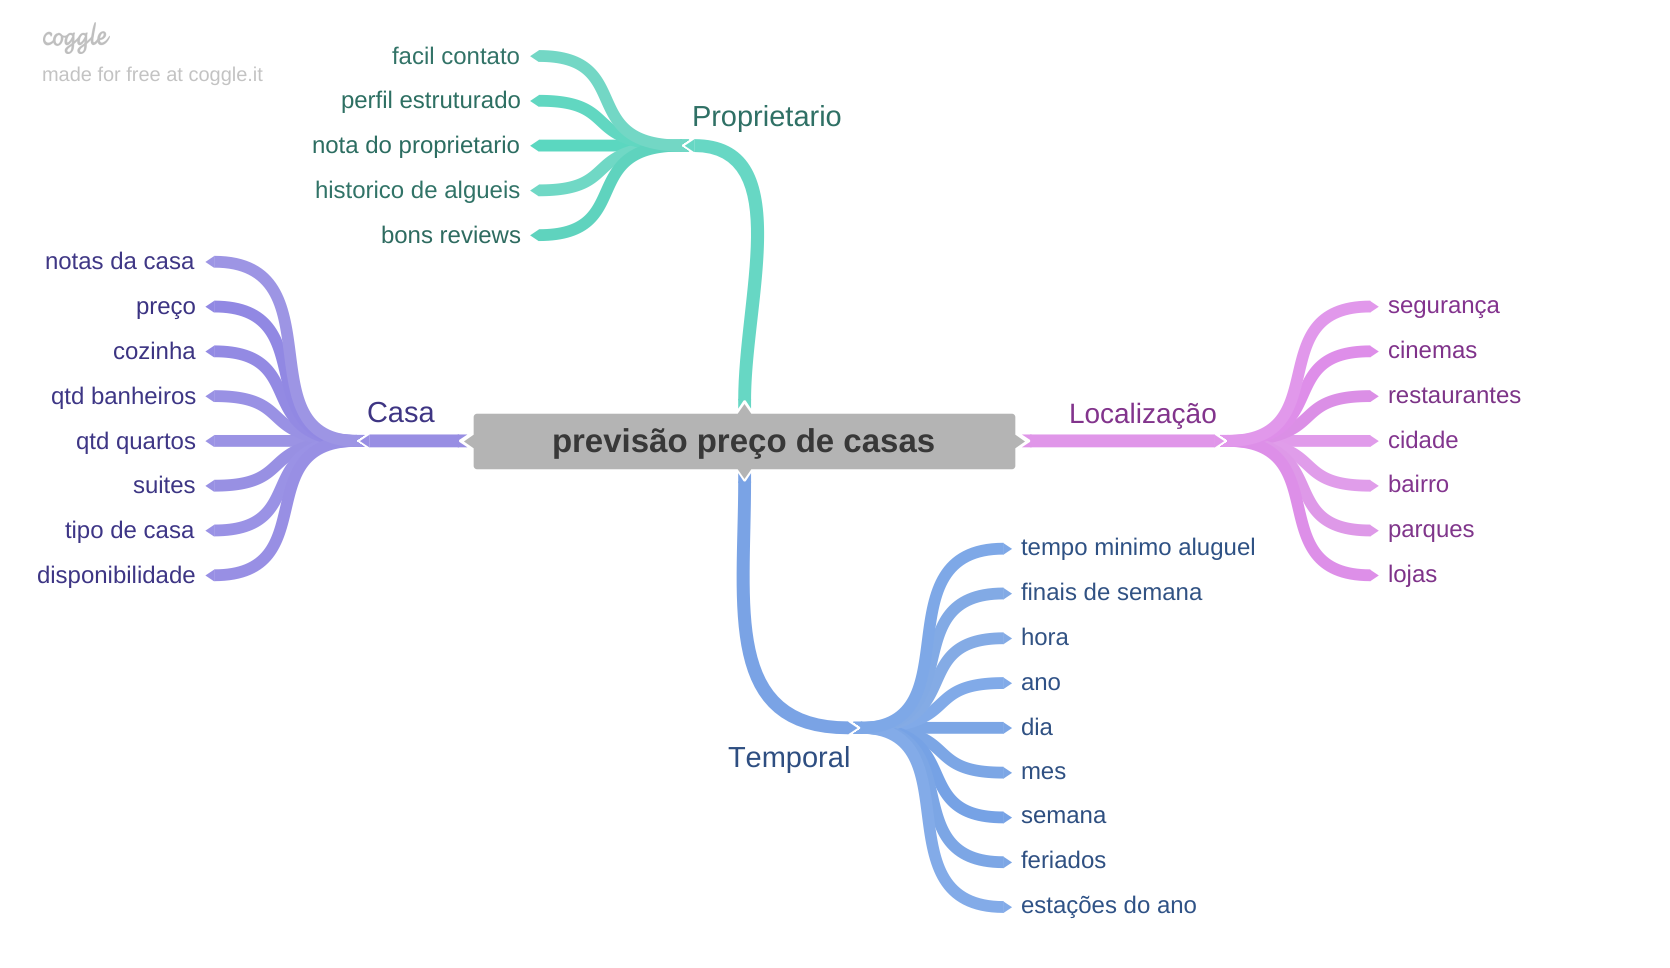

In [41]:
Image('../img/mind_map_preco_casa.png')

## 4.2. Criação de Hipóteses

### 4.2.1. Temporal

1. O preço das casas alugadas em periodo de feriados é mais alto
2. O preço das casas alugadas no inverno é mais caro
3. Casas com maior tempo de anuncio, tem o menor  numero de reviews
4. O preço das casas aumenta com o passar dos anos

### 4.2.2. Casa

1. Quantidade de quartos aumenta o preço da casa
2. Casas com maior tempo de disponibilidade, tem o mais numero_de_reviews
3. Apartamentos inteiros são mais caros que os outros tipos de casas
4. Casas com o menor preço são mais alugadas
5. Casas com maior quantidade de reviews tem preços maiores

### 4.2.3. Localização

1. Manhatam é o bairro mais caro
2. O tipo de casa menos comum no bairro tem o maior preço
3. Casas mais proximas a parques são mais caras
4. Bairros mais seguros tem casas mais caras
5. Bairros com maior quantidade de lojas, tem casas mais caras

## 4.3. Final List Hypotheses

1. Existe mais casas disponiveis com menos quantidade de noites exigidas para o aluguel
2. O preço das casas aumenta com o passar dos anos
3. Casas com maior tempo de anuncio, tem o menor  numero de reviews
4. Apartamentos inteiros são mais caros que os outros tipos de casas
5. Casas com maior quantidade de reviews tem preços maiores
6. Manhatam é o bairro mais caro


## 4.4. Saved Actual Data

In [42]:
path = '..\data\processed\df4_hypotesis_creation.csv'
df4.to_csv(path, index=False)

# 5.0. EDA

In [43]:
df5 = df4.copy()

In [44]:
df5.sample(5).T

,45413,47603,10724,38176,25677
id,34737386,35829544,8254674,30124940,20565375
nome,Great Duplex in Gramercy (private bedroom + bath),MURRAY HILL LUXURY APARTMENT,NOHO ART LOFT ON LAFAYETTE. BEST LOCATION IN NYC,Large second floor room for 4!,Luxury New 2 bed Apartment By Central Park North
host_id,15690228,221200420,4910739,65407018,138765458
host_name,Nicolas,Adam,Max,Harmony,Lilian
bairro_group,Manhattan,Manhattan,Manhattan,Brooklyn,Manhattan
bairro,Gramercy,Murray Hill,NoHo,Greenpoint,East Harlem
latitude,40.73676,40.74964,40.72847,40.7227,40.79674
longitude,-73.9842,-73.97203,-73.99302,-73.93691,-73.94674
room_type,Private room,Entire home/apt,Entire home/apt,Private room,Entire home/apt
price,1900,280,700,85,325


## 5.1. Analise Univariada

### 5.1.1. Variavel Resposta

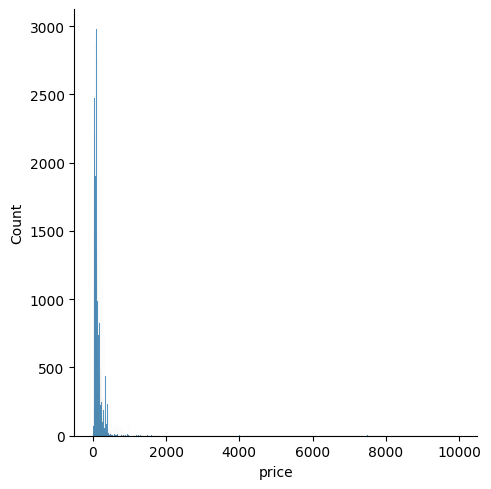

In [45]:
sns.displot(df5['price'])

### 5.1.2 Variaveis Numericas

In [46]:
get_descriptive_info(df5) 

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,2595.000000,3.648724e+07,3.648465e+07,1.901753e+07,1.967743e+07,1.098277e+07,-0.090265,-1.227738
1,host_id,2438.000000,2.743213e+08,2.743189e+08,6.762139e+07,3.079553e+07,7.861037e+07,1.206189,0.169041
2,latitude,40.499790,4.091306e+01,4.132700e-01,4.072895e+01,4.072308e+01,5.452883e-02,0.237157,0.148937
3,longitude,-74.244420,-7.371299e+01,5.314300e-01,-7.395217e+01,-7.395568e+01,4.615665e-02,1.284179,5.021498
4,price,0.000000,1.000000e+04,1.000000e+04,1.527208e+02,1.060000e+02,2.401542e+02,19.118743,585.660822
5,minimo_noites,1.000000,1.250000e+03,1.249000e+03,7.030085e+00,3.000000e+00,2.051053e+01,21.827092,854.056640
6,numero_de_reviews,0.000000,6.290000e+02,6.290000e+02,2.327476e+01,5.000000e+00,4.455054e+01,3.690589,19.529325
7,reviews_por_mes,-1.000000,5.850000e+01,5.950000e+01,8.853403e-01,3.700000e-01,1.778533e+00,2.452605,28.687688
8,calculado_host_listings_count,1.000000,3.270000e+02,3.260000e+02,7.144005e+00,1.000000e+00,3.295252e+01,7.933091,67.549426
9,disponibilidade_365,0.000000,3.650000e+02,3.650000e+02,1.127762e+02,4.500000e+01,1.316173e+02,0.763459,-0.997430


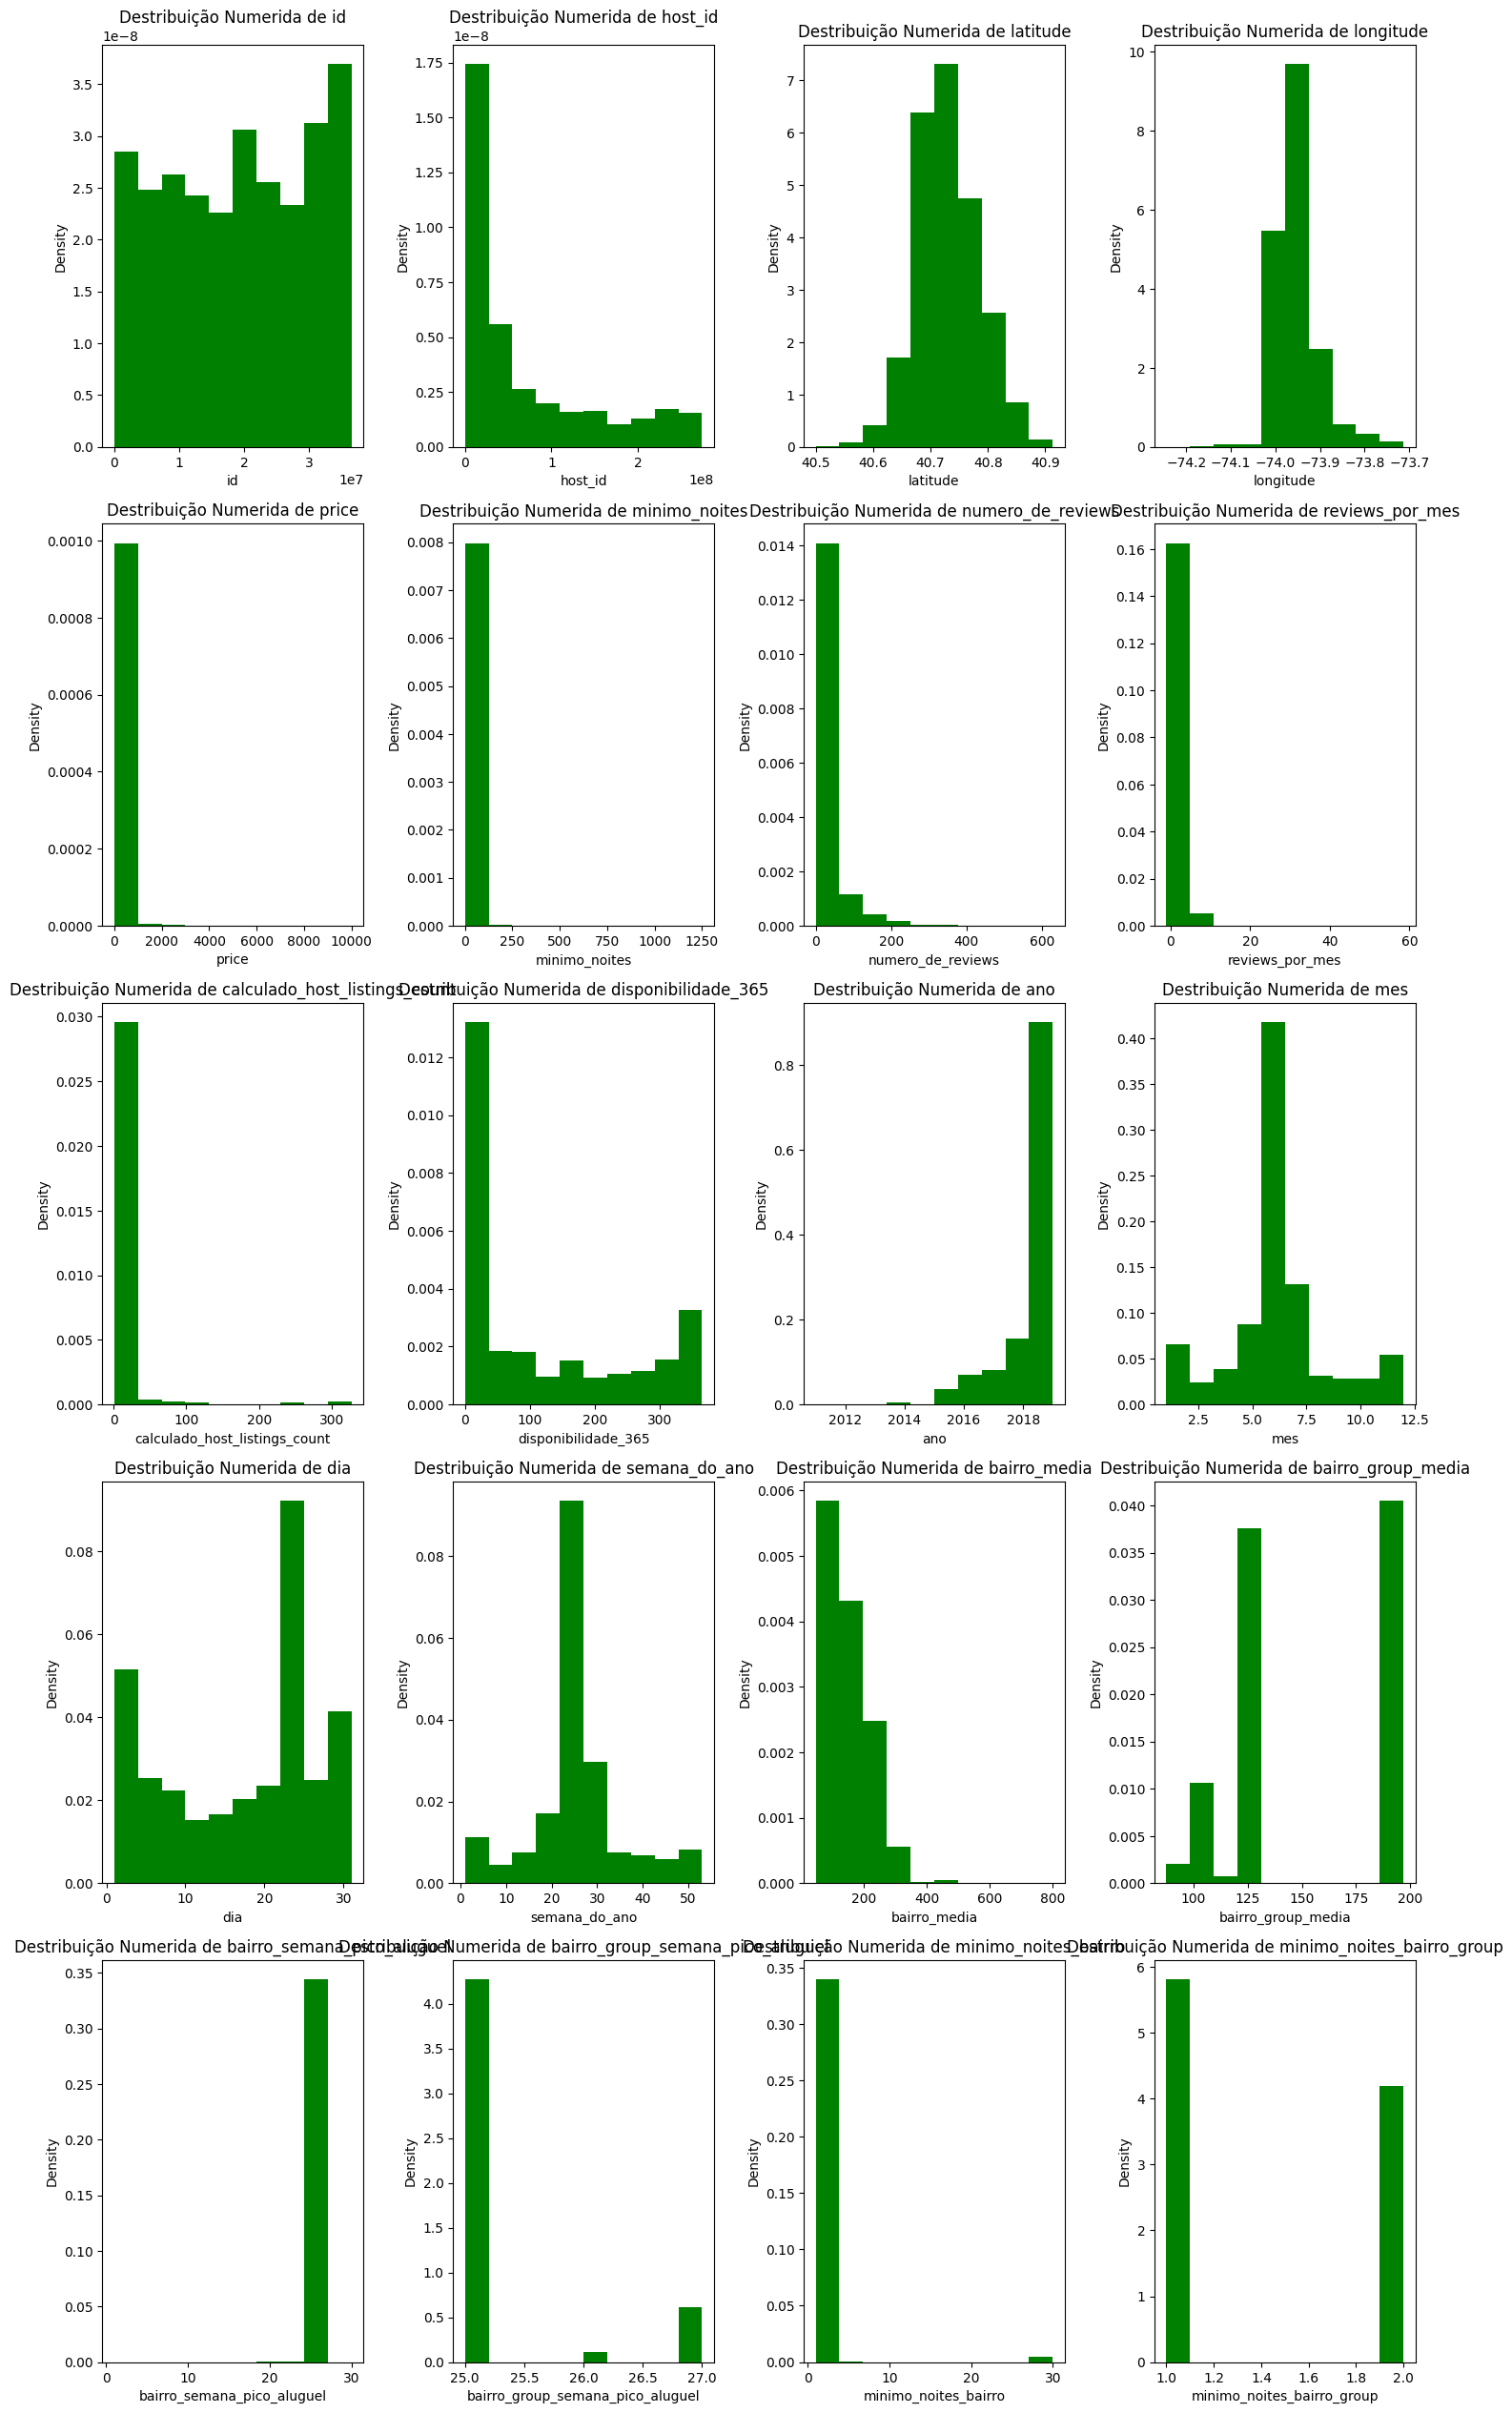

In [47]:
plot_numerical_distribution(df5)

### 5.2.3 Variaveis Categoricas

In [48]:
get_categorical_attributes(df5).dtypes

nome                      object
host_name                 object
bairro_group              object
bairro                    object
room_type                 object
ano_semana                object
room_type_bairro          object
room_type_bairro_group    object
dtype: object

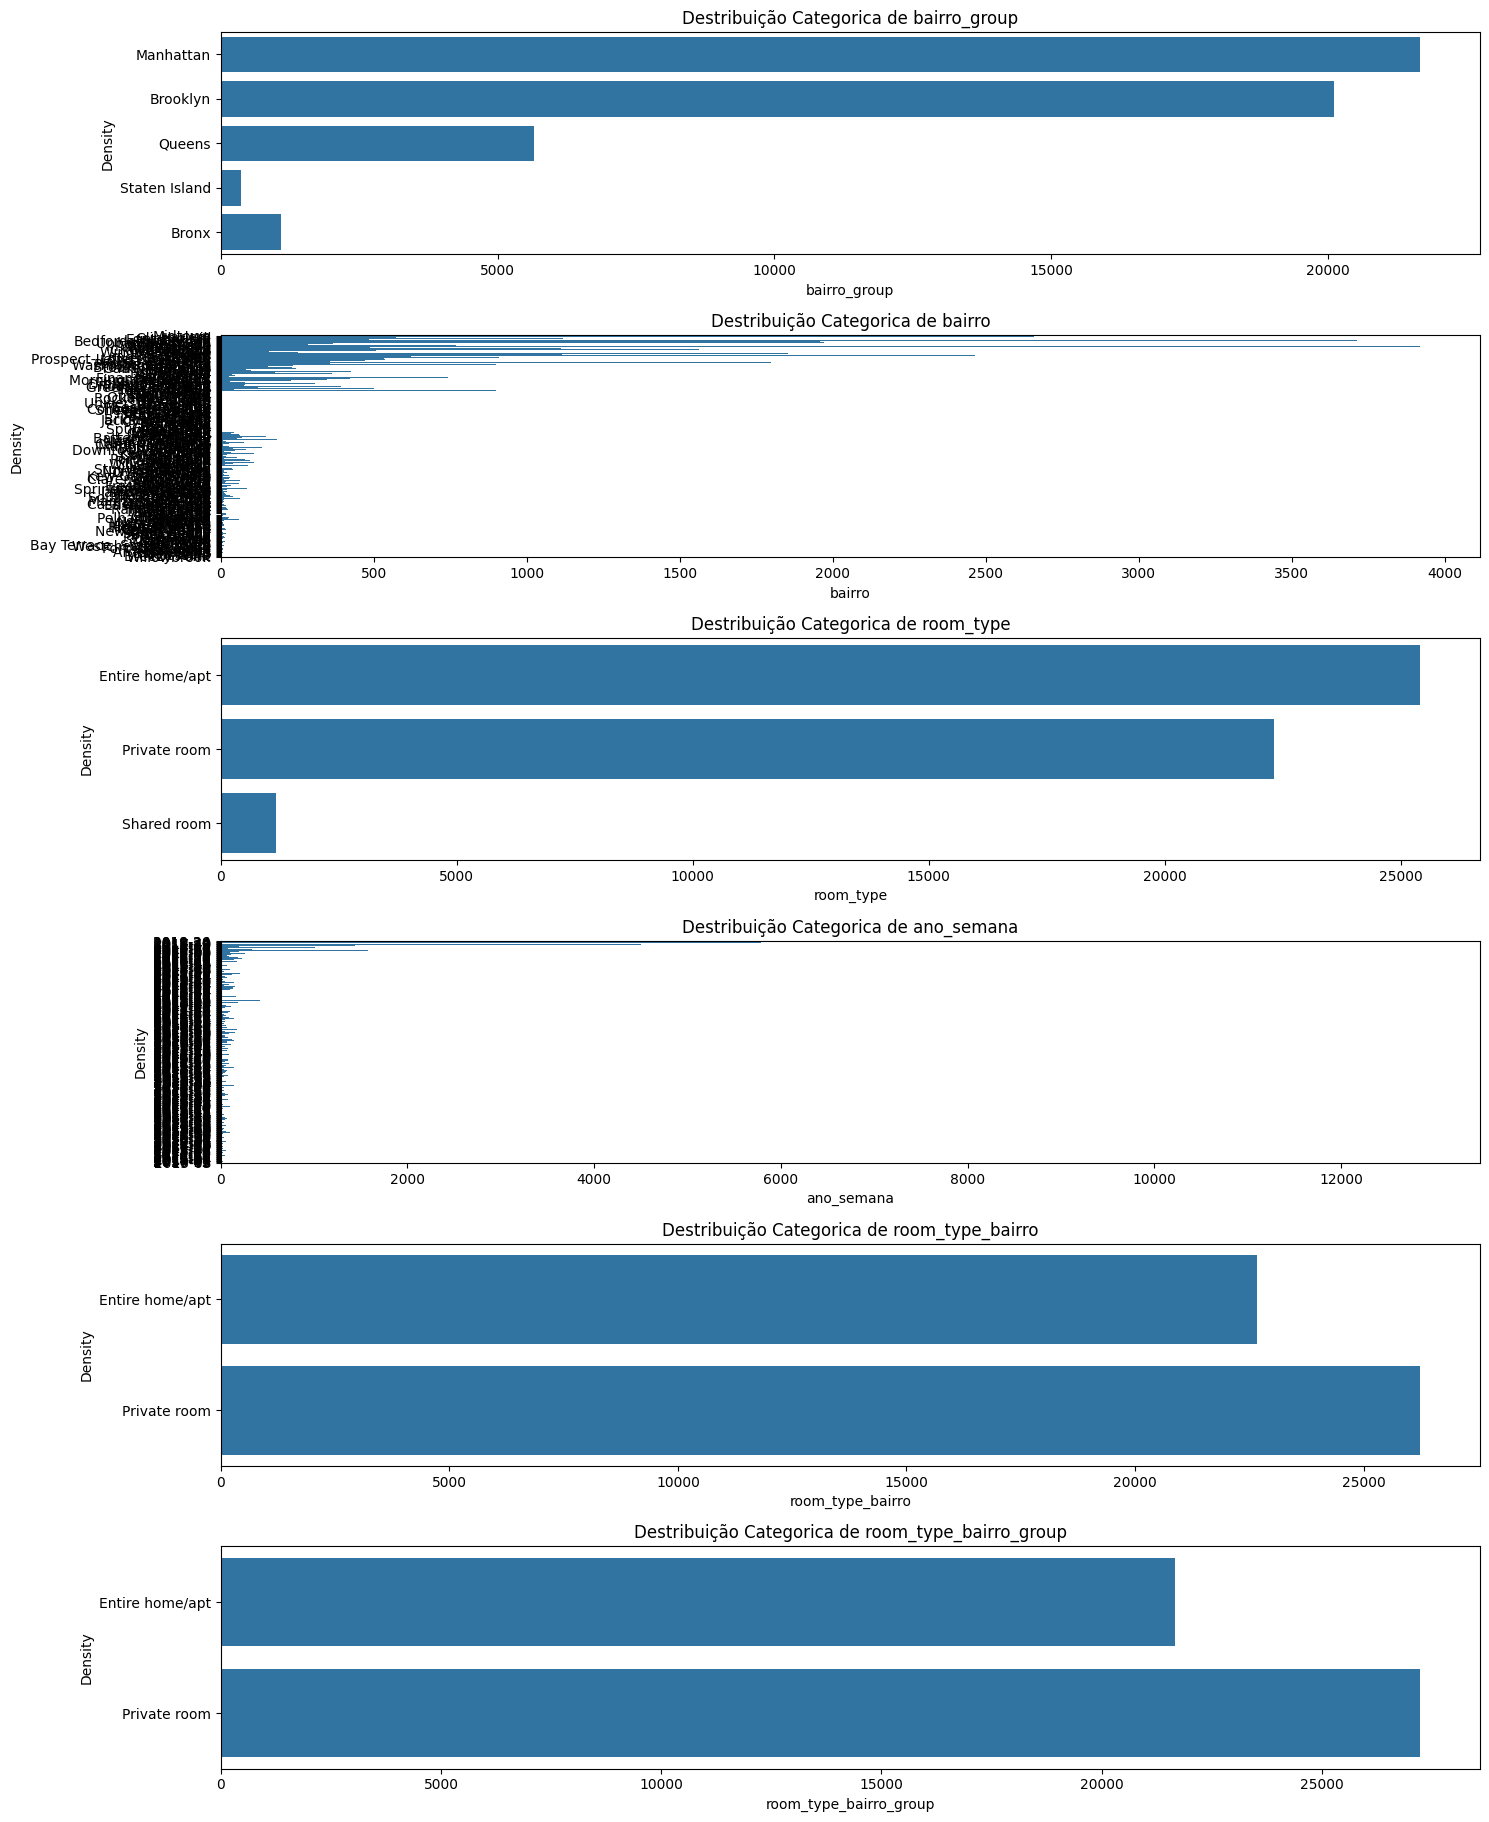

In [49]:
plot_categorical_distribution(df5.drop(columns=['nome', 'host_name']))

## 5.2. Analise Bivariada

### 5.2.1. Hipotese 1

1. Existe mais casas disponiveis com menos quantidade de noites exigidas para o aluguel

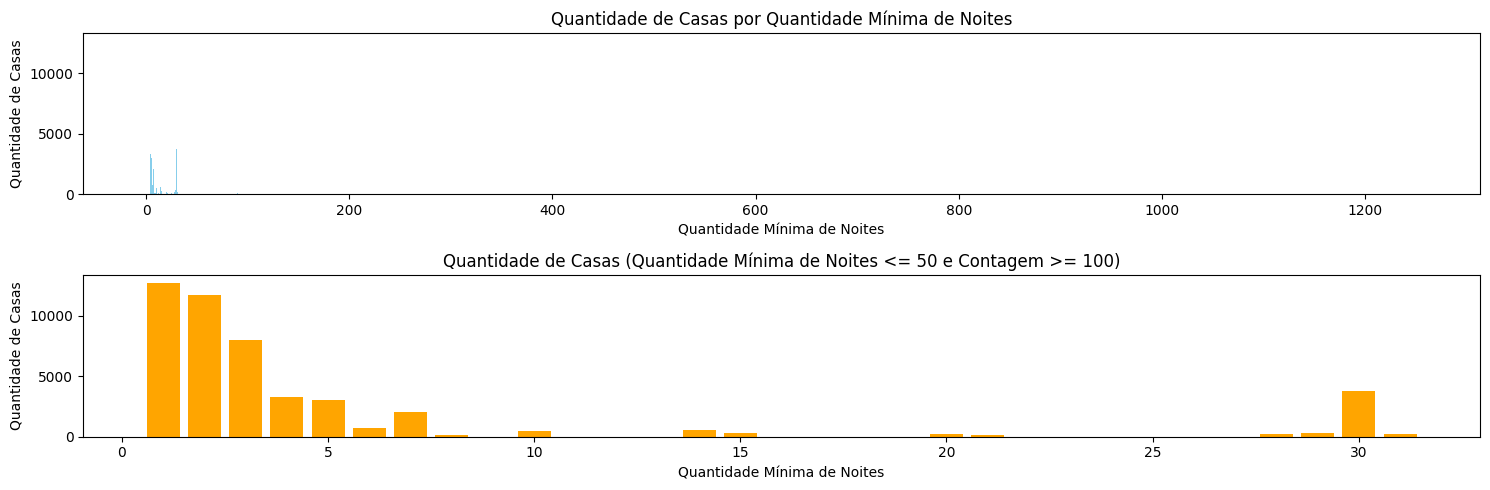

In [50]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Quantidade de casas por quantidade mínima de noites
plt.subplot(2, 1, 1)
quantidade_casas_por_noite = df5['minimo_noites'].value_counts().sort_index()
plt.bar(quantidade_casas_por_noite.index, quantidade_casas_por_noite.values, color='skyblue')
plt.title('Quantidade de Casas por Quantidade Mínima de Noites')
plt.xlabel('Quantidade Mínima de Noites')
plt.ylabel('Quantidade de Casas')

# Subplot 2 - Contagem de entradas filtradas (<= 50 e >= 100)
plt.subplot(2, 1, 2)
filtro = (quantidade_casas_por_noite.index <= 50) & (quantidade_casas_por_noite.values >= 100)
quantidade_casas_por_noite_filtrado = quantidade_casas_por_noite[filtro]
plt.bar(quantidade_casas_por_noite_filtrado.index, quantidade_casas_por_noite_filtrado.values, color='orange')
plt.title('Quantidade de Casas (Quantidade Mínima de Noites <= 50 e Contagem >= 100)')
plt.xlabel('Quantidade Mínima de Noites')
plt.ylabel('Quantidade de Casas')

plt.tight_layout()
plt.show()

### 5.2.2. Hipotese 2

2. O preço das casas aumenta com o passar dos anos

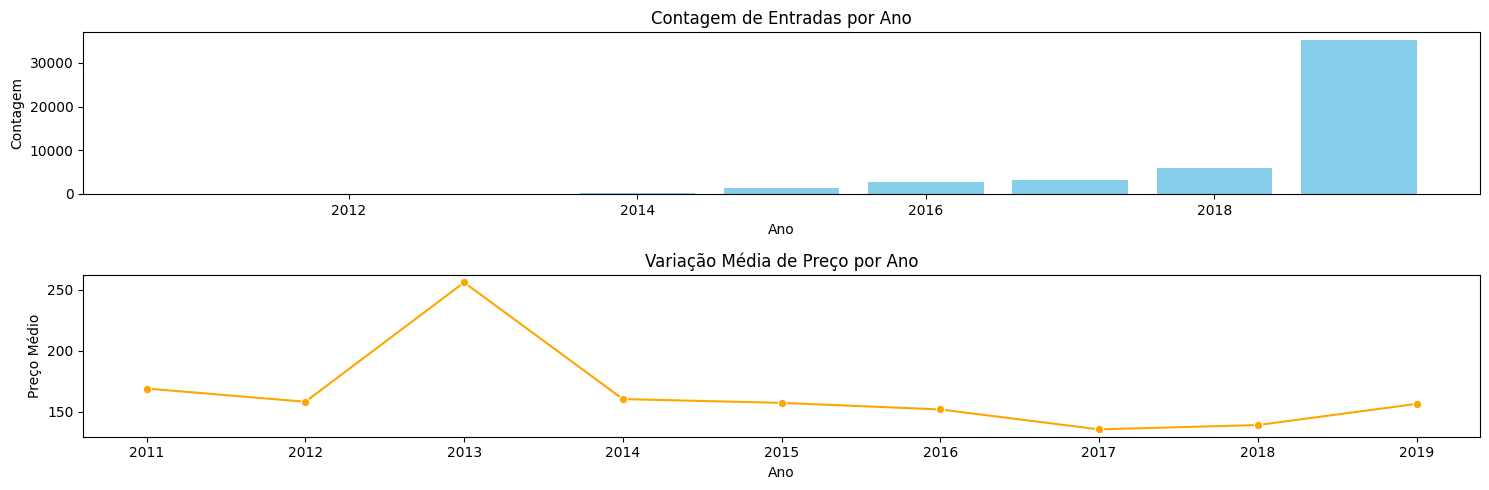

In [51]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Contagem de entradas por ano
plt.subplot(2, 1, 1)
aux1 = df5['ano'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Contagem de Entradas por Ano')
plt.xlabel('Ano')
plt.ylabel('Contagem')

# Subplot 2 - Variação média de preço por ano
plt.subplot(2, 1, 2)
aux2 = df5.groupby('ano')['price'].mean().reset_index()
sns.lineplot(x='ano', y='price', data=aux2, marker='o', color='orange')
plt.title('Variação Média de Preço por Ano')
plt.xlabel('Ano')
plt.ylabel('Preço Médio')

plt.tight_layout()
plt.show()


### 5.2.3. Hipotese 3

3. Casas com maior tempo de anuncio, tem o menor  numero de reviews

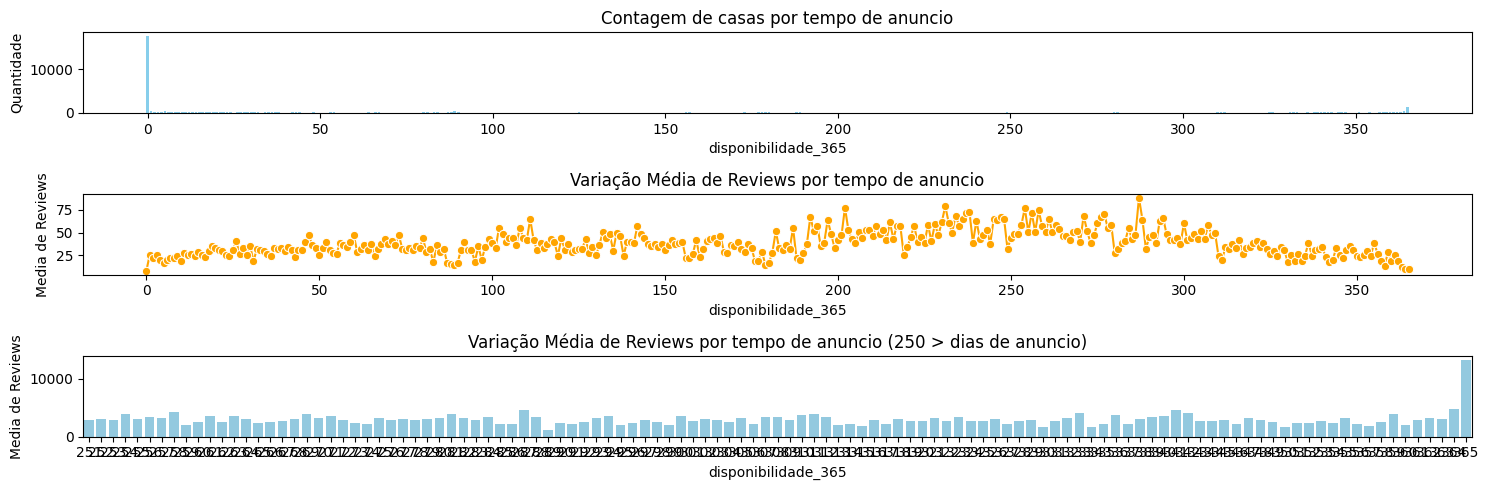

In [52]:
plt.figure(figsize=(15, 5))

# Subplot 1 - Quantidade de casas por tempo de anuncio
plt.subplot(3, 1, 1)
aux1 = df5['disponibilidade_365'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Contagem de casas por tempo de anuncio')
plt.xlabel('disponibilidade_365')
plt.ylabel('Quantidade')

# Subplot 2 - Variação Média de Reviews por tempo de anuncio
plt.subplot(3, 1, 2)
aux2 = df5.groupby('disponibilidade_365')['numero_de_reviews'].mean().reset_index()
sns.lineplot(x='disponibilidade_365', y='numero_de_reviews', data=aux2, marker='o', color='orange')
plt.title('Variação Média de Reviews por tempo de anuncio')
plt.xlabel('disponibilidade_365')
plt.ylabel('Media de Reviews')

# Subplot 3 - Variação Média de Reviews por tempo de anuncio filtro com dias > 250
plt.subplot(3, 1, 3)
aux1 = df5[['disponibilidade_365', 'numero_de_reviews']].groupby(['disponibilidade_365']).sum().reset_index()
aux1 = aux1[(aux1['disponibilidade_365'] > 250)]
sns.barplot(x='disponibilidade_365', y='numero_de_reviews', data=aux1, color='skyblue');
plt.title('Variação Média de Reviews por tempo de anuncio (250 > dias de anuncio)')
plt.xlabel('disponibilidade_365')
plt.ylabel('Media de Reviews')


plt.tight_layout()
plt.show()


### 5.2.4. Hipotese 4

4. Apartamentos inteiros são mais caros que os outros tipos de casas

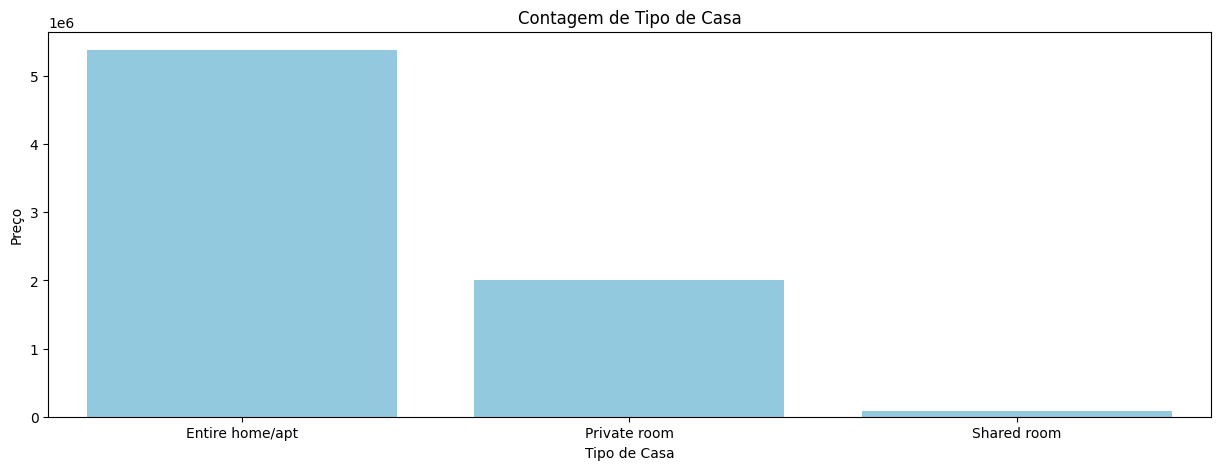

In [53]:
plt.figure(figsize=(15, 5))
# Plot 1 - Soma total do Tipo de Casa 
aux1 = df5[['room_type', 'price']].groupby('room_type').sum().reset_index()
sns.barplot(x='room_type', y='price', data=aux1, color='skyblue');
plt.title('Contagem de Tipo de Casa')
plt.xlabel('Tipo de Casa')
plt.ylabel('Preço')
plt.show()

Text(0, 0.5, 'Price')

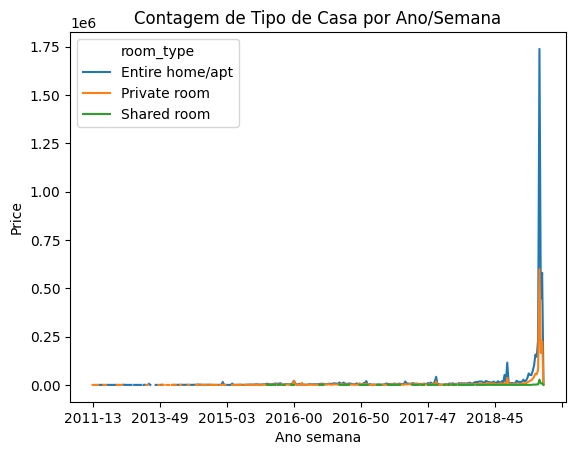

In [54]:
aux2 = df5[['ano_semana', 'room_type', 'price']].groupby(['ano_semana','room_type']).sum().reset_index()
aux2.pivot(index='ano_semana', columns='room_type', values='price').plot()
plt.title('Contagem de Tipo de Casa por Ano/Semana')
plt.xlabel('Ano semana')
plt.ylabel('Price')

### 5.2.5. Hipotese 5

5. Casas com maior quantidade de reviews tem preços maiores

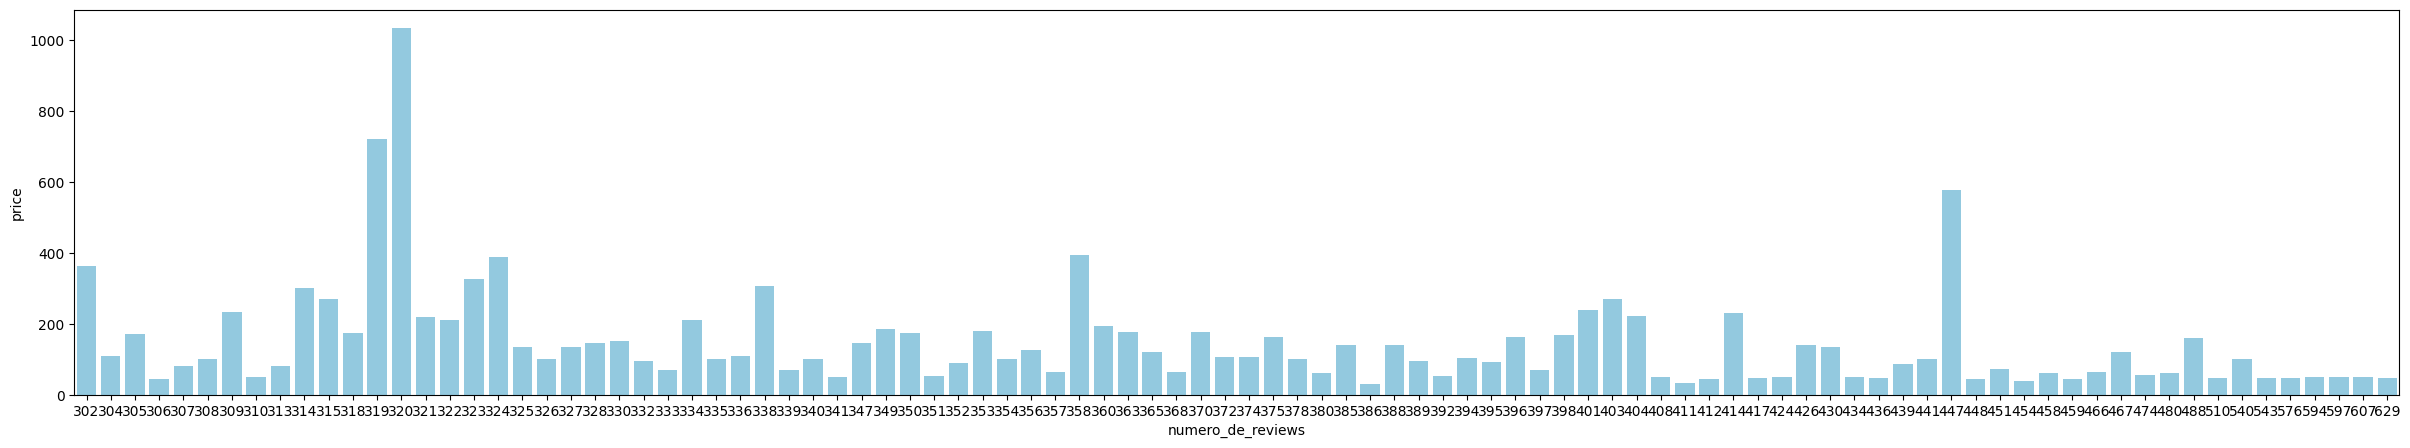

In [55]:
# Plot 1 - Soma total do Tipo de Casa 
plt.figure(figsize=(30,5))
aux1 = df5[['numero_de_reviews', 'price']].groupby(['numero_de_reviews']).sum().reset_index()
aux1 = aux1[(aux1['numero_de_reviews'] > 300) & (aux1['numero_de_reviews'] != 0)]
sns.barplot(x='numero_de_reviews', y='price', data=aux1, color='skyblue');
plt.show()

### 5.2.6. Hipotese 6

6. Manhatam é o bairro mais caro

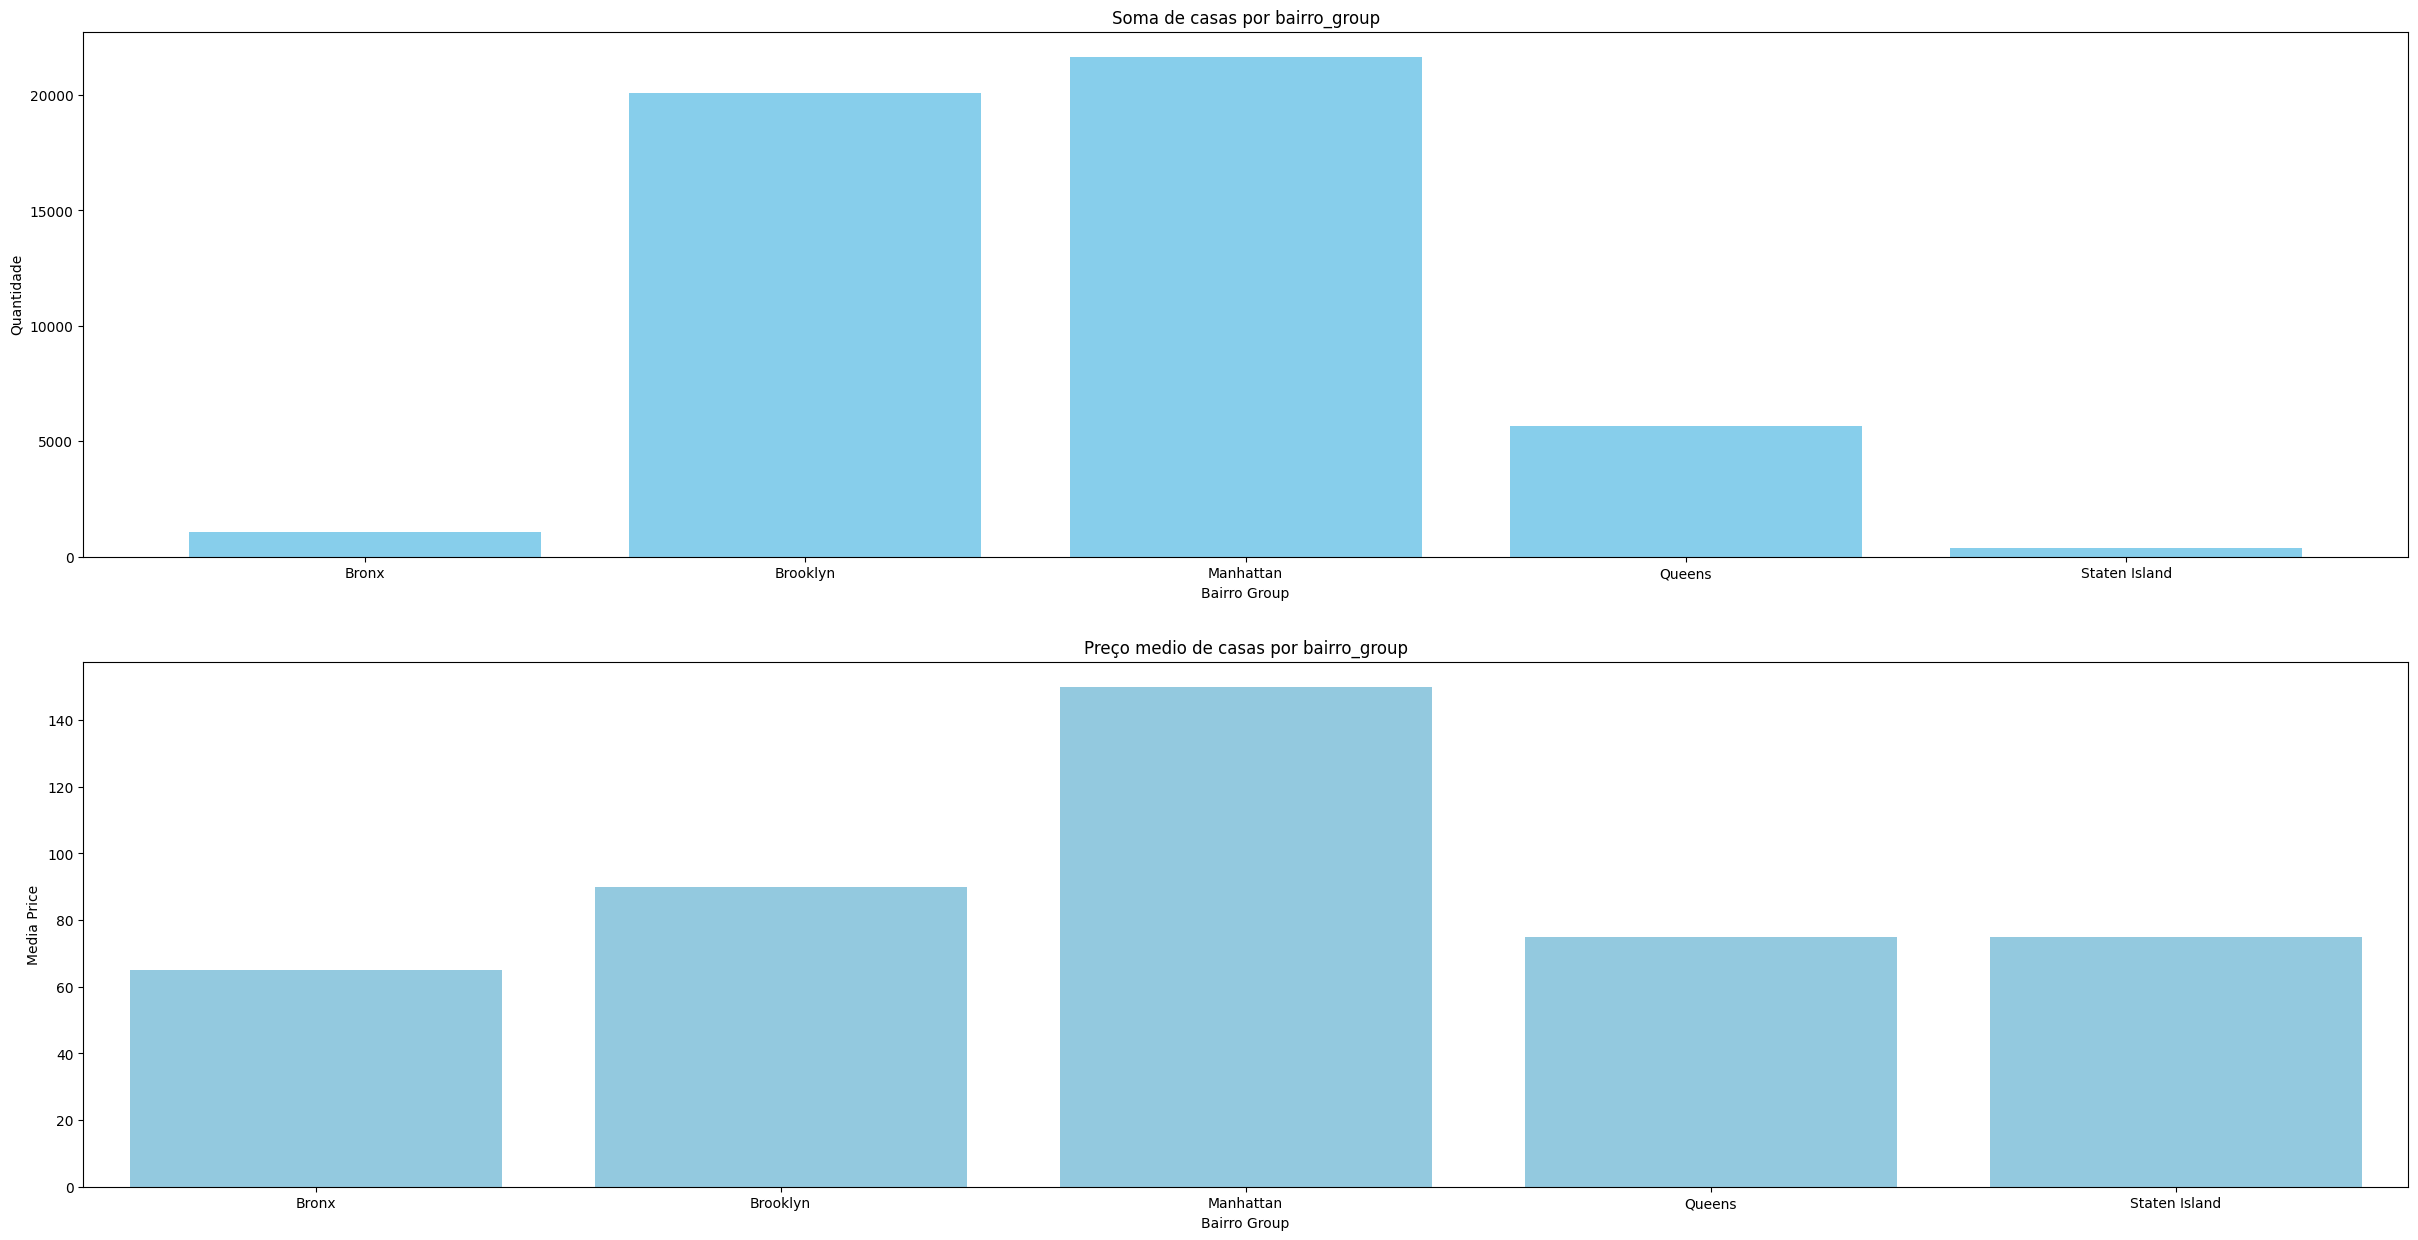

In [56]:
plt.figure(figsize=(30,15))

# Plot 1 - Soma total de casas por bairro_group
plt.subplot(2, 1, 1)
aux1 = df5['bairro_group'].value_counts().sort_index()
plt.bar(aux1.index, aux1.values, color='skyblue')
plt.title('Soma de casas por bairro_group')
plt.xlabel('Bairro Group')
plt.ylabel('Quantidade')

# Plot 2 - Preço medio de casas por bairro_group
plt.subplot(2, 1, 2)
aux1 = df5[['bairro_group', 'price']].groupby(['bairro_group']).median().reset_index()
sns.barplot(x='bairro_group', y='price', data=aux1, color='skyblue');
plt.title('Preço medio de casas por bairro_group')
plt.xlabel('Bairro Group')
plt.ylabel('Media Price')

plt.show()

## 5.3. Analise Multivariada

### 5.3.1. Numerical Attributes

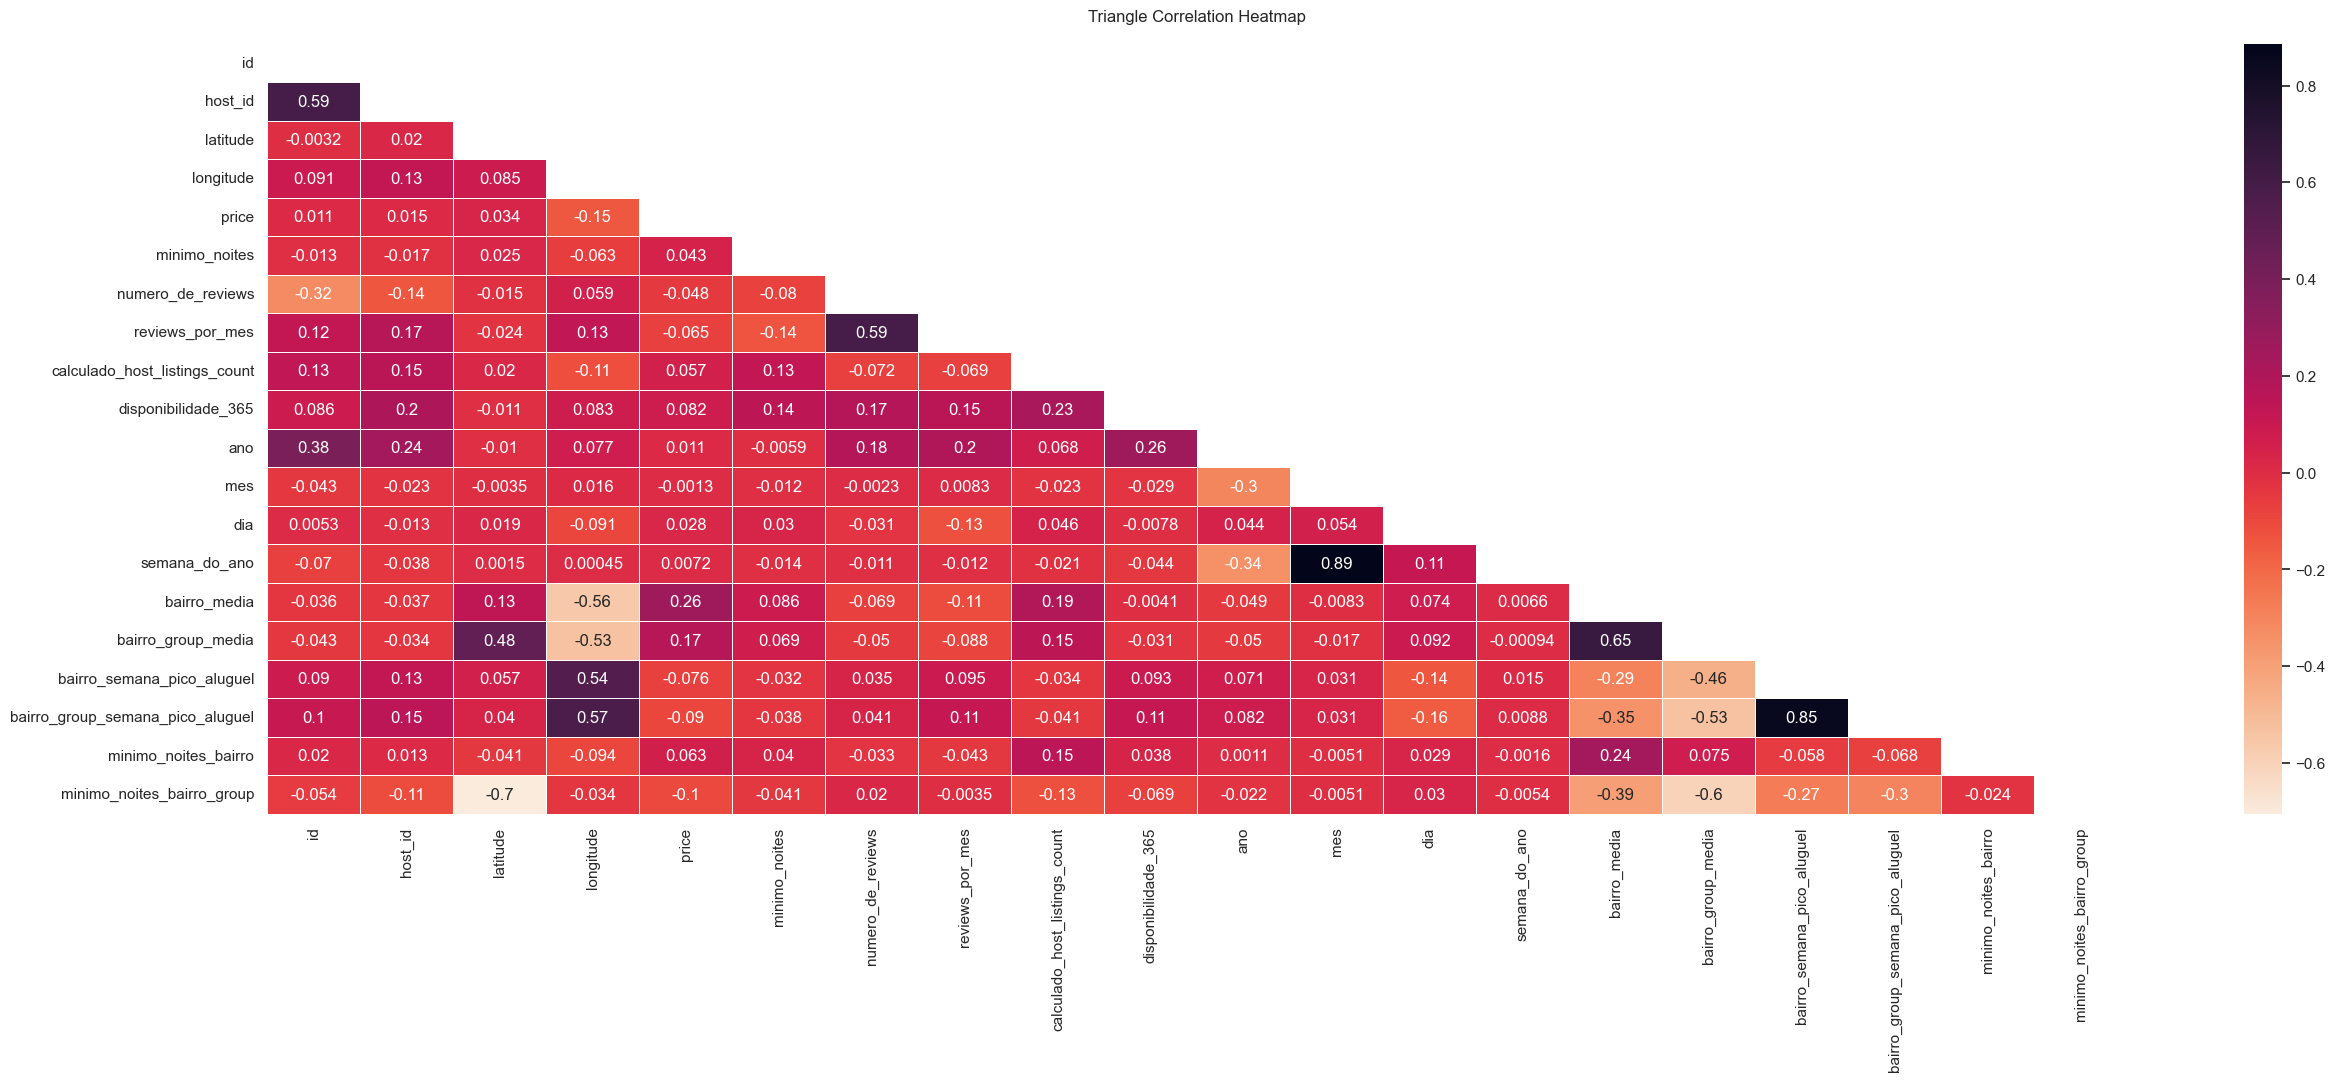

In [57]:
num_attributes = get_numerical_attributes(df5)
plot_triangle_correlation_heatmap(num_attributes.corr(method='pearson'))

### 5.3.2. Categorical Attributes

In [58]:
cat_attributes = get_categorical_attributes(df5)
cat_attributes.columns

Index(['nome', 'host_name', 'bairro_group', 'bairro', 'room_type',
       'ano_semana', 'room_type_bairro', 'room_type_bairro_group'],
      dtype='object')

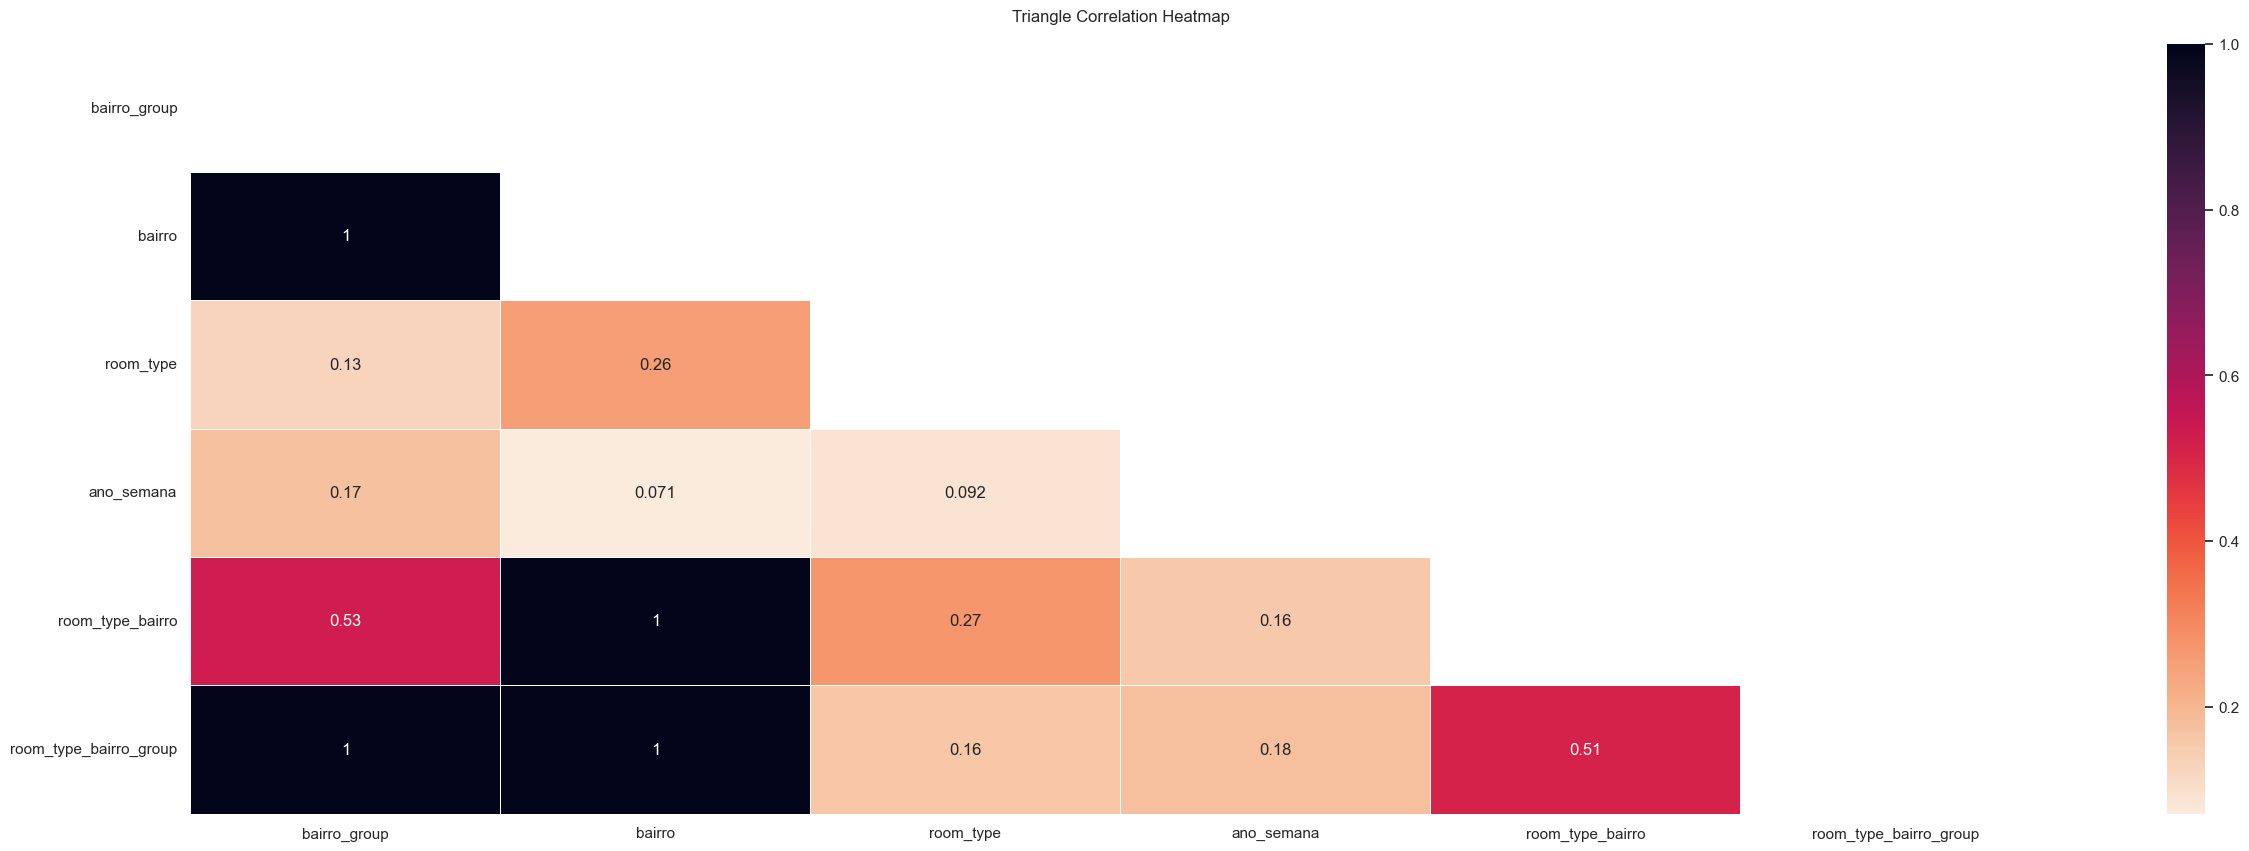

In [59]:
a1 = cramer_v(cat_attributes['bairro_group'], cat_attributes['bairro_group'])
a2 = cramer_v(cat_attributes['bairro_group'], cat_attributes['bairro'])
a3 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type'])
a4 = cramer_v(cat_attributes['bairro_group'], cat_attributes['ano_semana'])
a5 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type_bairro'])
a6 = cramer_v(cat_attributes['bairro_group'], cat_attributes['room_type_bairro_group'])

b1 = cramer_v(cat_attributes['bairro'], cat_attributes['bairro_group'])
b2 = cramer_v(cat_attributes['bairro'], cat_attributes['bairro'])
b3 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type'])
b4 = cramer_v(cat_attributes['bairro'], cat_attributes['ano_semana'])
b5 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type_bairro'])
b6 = cramer_v(cat_attributes['bairro'], cat_attributes['room_type_bairro_group'])

c1 = cramer_v(cat_attributes['room_type'], cat_attributes['bairro_group'])
c2 = cramer_v(cat_attributes['room_type'], cat_attributes['bairro'])
c3 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type'])
c4 = cramer_v(cat_attributes['room_type'], cat_attributes['ano_semana'])
c5 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type_bairro'])
c6 = cramer_v(cat_attributes['room_type'], cat_attributes['room_type_bairro_group'])

d1 = cramer_v(cat_attributes['ano_semana'], cat_attributes['bairro_group'])
d2 = cramer_v(cat_attributes['ano_semana'], cat_attributes['bairro'])
d3 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type'])
d4 = cramer_v(cat_attributes['ano_semana'], cat_attributes['ano_semana'])
d5 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type_bairro'])
d6 = cramer_v(cat_attributes['ano_semana'], cat_attributes['room_type_bairro_group'])

e1 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['bairro_group'])
e2 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['bairro'])
e3 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type'])
e4 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['ano_semana'])
e5 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type_bairro'])
e6 = cramer_v(cat_attributes['room_type_bairro'], cat_attributes['room_type_bairro_group'])

f1 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['bairro_group'])
f2 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['bairro'])
f3 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type'])
f4 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['ano_semana'])
f5 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type_bairro'])
f6 = cramer_v(cat_attributes['room_type_bairro_group'], cat_attributes['room_type_bairro_group'])

cat_df = pd.DataFrame({'bairro_group': [a1, a2, a3, a4, a5, a6],
                       'bairro': [b1, b2, b3, b4, b5, b6],
                       'room_type': [c1, c2, c3, c4, c5, c6],
                       'ano_semana': [d1, d2, d3, d4, d5, d6],
                       'room_type_bairro': [e1, e2, e3, e4, e5, e6],
                       'room_type_bairro_group': [f1, f2, f3, f4, f5, f6]})

cat_df = cat_df.set_index(cat_df.columns)

plot_triangle_correlation_heatmap(cat_df)

## 5.4. Saved Actual Data

In [60]:
path = '..\data\processed\df5_exploratory_data_analysis.csv'
df5.to_csv(path, index=False)